# Sobol indices

In [7]:
import openturns as ot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Gaussian Framework

In [8]:
from shapley.tests import AdditiveGaussian
dim = 2
beta = None
model = AdditiveGaussian(dim=dim, beta=beta)
theta = [0.3]
model.copula_parameters = theta

if True:
    dim = 3
    beta = None
    model = AdditiveGaussian(dim=dim, beta=beta)
    model.margins = [ot.Normal()]*(dim-1) + [ot.Normal(0, 2.)]
    theta = [0., 0., 0.5]
    model.copula_parameters = theta

### Monte-Carlo estimation using true model

In [33]:
%%time
from shapley import ShapleyIndices
ot.RandomGenerator.SetSeed(0)
np.random.seed(0)

n_perms = None
Nv = 1000
No = 100
Ni = 10

budget_perms = np.math.factorial(dim) if n_perms is None else n_perms
max_budget = Nv + No * Ni * budget_perms * (dim - 1)
print('Max budget:', max_budget)

shapley = ShapleyIndices(model.input_distribution)
shapley.build_sample(model=model, n_perms=n_perms, Nv=Nv, No=No, Ni=Ni)

Max budget: 13000
CPU times: user 3.84 s, sys: 996 ms, total: 4.83 s
Wall time: 2.68 s


In [34]:
%%time
ot.RandomGenerator.SetSeed(0)
np.random.seed(0)

n_boot = 1000
shapley_results = shapley.compute_indices(n_boot=n_boot)

CPU times: user 1.38 s, sys: 20 ms, total: 1.4 s
Wall time: 502 ms


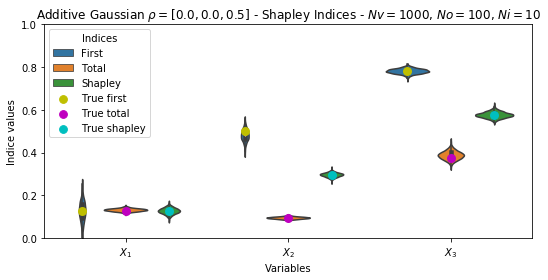

In [35]:
from shapley.plots import plot_sensitivity_results
ylim = [0., 1.]

fig, ax = plt.subplots(figsize=(8, 4))
plot_sensitivity_results(shapley_results, indice='all', ax=ax)
ax.set_title("Additive Gaussian $\\rho = {0}$ - Shapley Indices - $Nv={1}$, $No={2}$, $Ni={3}$".format(theta, Nv, No, Ni))
ax.set_ylim(ylim)
fig.tight_layout()

### Monte-Carlo estimation using a Kriging model

In [6]:
from shapley.kriging import KrigingModel
ot.RandomGenerator.SetSeed(0)
np.random.seed(0)

model_budget = 20
sampling = 'lhs'
library = 'sklearn'
kernel = 'matern'
basis = 'linear'

model_gp = KrigingModel(model=model, input_distribution=model.input_distribution)
model_gp.generate_sample(n_sample=model_budget, sampling=sampling, copula='independent')
model_gp.build(library=library, kernel=kernel, basis_type=basis)

In [7]:
# The score of the meta_model
q2_score_cv_gp = model_gp.compute_score_q2_cv(n_sample=10000, sampling='monte-carlo')
print('Q2-score by cross-validation:', q2_score_cv_gp)

Q2-score by cross-validation: 0.967402993792


In [8]:
%%time
n_realization = 500
shapley.build_sample(model=model_gp, n_perms=n_perms, Nv=Nv, No=No, Ni=Ni, n_realization=n_realization)

Sample size is too large. A loop is done to save memory.
3050
i_p: 0
i_p: 1
i_p: 2
i_p: 3
Wall time: 48.2 s


In [9]:
%%time
# Indice estimation
n_boot = 1000
shapley_gp_results = shapley.compute_indices(n_boot=n_boot)
shapley_gp_results.true_first_indices = model.first_order_sobol_indices
shapley_gp_results.true_total_indices = model.total_sobol_indices
shapley_gp_results.true_shapley_indices = model.shapley_indices

Wall time: 1min 53s


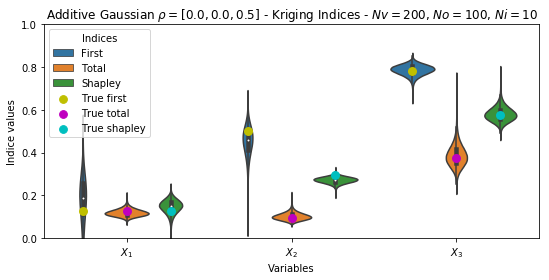

In [10]:
fig, ax = plt.subplots(figsize=(8, 4))
plot_sensitivity_results(shapley_gp_results, indice='all', ax=ax)
ax.set_title("Additive Gaussian $\\rho = {0}$ - Kriging Indices - $Nv={1}$, $No={2}$, $Ni={3}$".format(theta, Nv, No, Ni))
ax.set_ylim(ylim)
fig.tight_layout()

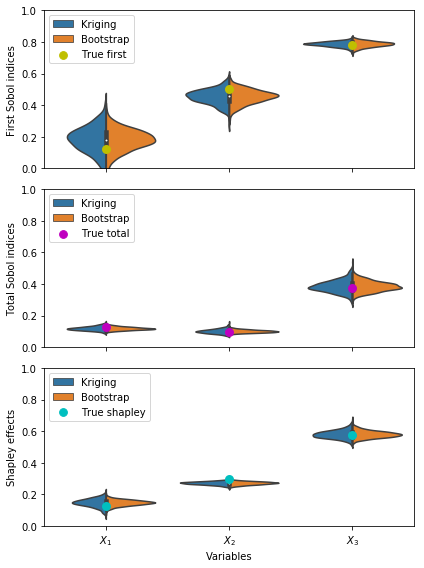

In [11]:
fig, axes = plt.subplots(3, 1, figsize=(6, 8), sharex=True, sharey=True)

ax = axes[0]
plot_sensitivity_results(shapley_kriging_results, indice='first', ax=ax)
ax.set_ylim(ylim)
ax.set_xlabel('')
ax.set_ylabel('First Sobol indices')
ax.legend(loc=2)

ax = axes[1]
plot_sensitivity_results(shapley_kriging_results, indice='total', ax=ax)
ax.set_ylim(ylim)
ax.legend(loc=2)
ax.set_xlabel('')
ax.set_ylabel('Total Sobol indices')

ax = axes[2]
plot_sensitivity_results(shapley_kriging_results, indice='shapley', ax=ax)
ax.set_ylim(ylim)
ax.legend(loc=2)
ax.set_ylabel('Shapley effects')

fig.tight_layout()

### Monte-Carlo estimation using a Random Forest model

In [12]:
from shapley.forest import RandomForestModel
ot.RandomGenerator.SetSeed(0)
np.random.seed(0)

model_rf = RandomForestModel(model=model, input_distribution=model.input_distribution)
model_rf.generate_sample(n_sample=model_budget, sampling=sampling)
model_rf.build(n_realization, method='random-forest')

In [13]:
# The score of the meta_model
q2_score_cv_rf = model_rf.compute_score_q2_cv(n_sample=10000, sampling='monte-carlo')
print('Q2-score by cross-validation:', q2_score_cv_rf)

Q2-score by cross-validation: 0.81139308761


In [14]:
%%time
shapley.build_sample(model=model_rf, n_perms=n_perms, Nv=Nv, No=No, Ni=Ni, n_realization=n_realization)

Wall time: 1.44 s


In [15]:
%%time
shapley_rf_results = shapley.compute_indices(n_boot=n_boot)
shapley_rf_results.true_first_indices = model.first_order_sobol_indices
shapley_rf_results.true_total_indices = model.total_sobol_indices
shapley_rf_results.true_shapley_indices = model.shapley_indices

Wall time: 1min 4s


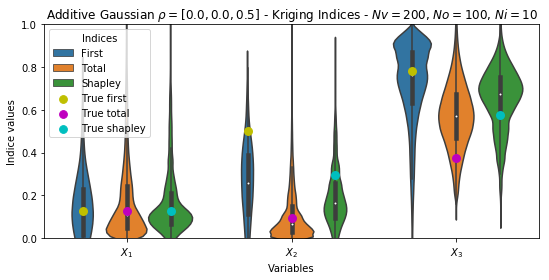

In [16]:
fig, ax = plt.subplots(figsize=(8, 4))
plot_sensitivity_results(shapley_rf_results, indice='all', ax=ax)
ax.set_title("Additive Gaussian $\\rho = {0}$ - Kriging Indices - $Nv={1}$, $No={2}$, $Ni={3}$".format(theta, Nv, No, Ni))
ax.set_ylim(ylim)
fig.tight_layout()

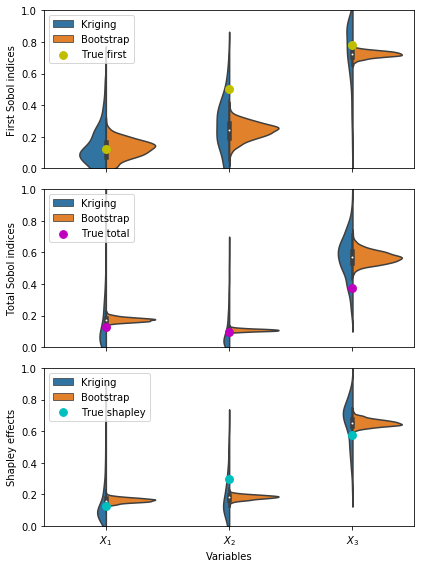

In [17]:
fig, axes = plt.subplots(3, 1, figsize=(6, 8), sharex=True, sharey=True)

ax = axes[0]
plot_sensitivity_results(shapley_rf_results, indice='first', ax=ax)
ax.set_ylim(ylim)
ax.set_xlabel('')
ax.set_ylabel('First Sobol indices')
ax.legend(loc=2)

ax = axes[1]
plot_sensitivity_results(shapley_rf_results, indice='total', ax=ax)
ax.set_ylim(ylim)
ax.legend(loc=2)
ax.set_xlabel('')
ax.set_ylabel('Total Sobol indices')

ax = axes[2]
plot_sensitivity_results(shapley_rf_results, indice='shapley', ax=ax)
ax.set_ylim(ylim)
ax.legend(loc=2)
ax.set_ylabel('Shapley effects')

fig.tight_layout()